In [ ]:
!pip install -U langchain-nomic langchain_community tiktoken langchainhub chromadb langchain langgraph tavily-python "httpx==0.27.2"

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader # 웹에서 데이터를 가져옵니다
from langchain_community.vectorstores import Chroma # 텍스트 데이터를 벡터화하고 검색 가능한 벡터 저장소를 구축합니다
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain import hub # 랭체인의 허브 기능으로 사전 정의된 체인, 도구, 프롬프트 등을 사용

In [ ]:
import os
os.environ["TAVILY_API_KEY"] = "tvly"
os.environ["OPENAI_API_KEY"] = "sk" #openai 키 입력

In [ ]:
llm = ChatOpenAI(model="gpt-4o", temperature=0, streaming=True)
embed_model = OpenAIEmbeddings()

<ipython-input-4-9978a0cb3692>:1: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model="gpt-4o", temperature=0, streaming=True)
<ipython-input-4-9978a0cb3692>:2: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embed_model = OpenAIEmbeddings()


In [ ]:
prompt = hub.pull("rlm/rag-prompt")

generation_chain = prompt | llm

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [ ]:
urls = [
    "https://www.promptingguide.ai/kr",
    "https://www.promptingguide.ai/kr/introduction/basics",
] # 텍스트 데이터를 가져올 웹 페이지의 URL 목록

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

In [ ]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=512, chunk_overlap=0
) # 긴 텍스트 데이터를 일정한 크기의 청크(chunks)로 분할, 각 청크의 최대 크기를 512 토큰으로 설정
doc_splits = text_splitter.split_documents(docs_list) # docs_list에 있는 텍스트 데이터를 chunk_size=512 크기로 분할

In [ ]:
vectorstore = Chroma.from_documents(documents=doc_splits,
                                    collection_name="chroma",
                                    persist_directory="/content/chroma", # 해당 위치는 임시 저장소이므로 영구 저장을 위해서는 경로를 변경해야 합니다
                                    embedding=embed_model) # 텍스트 문서를 벡터화하고 저장소를 생성

In [ ]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 2}) # 벡터 저장소를 검색할 수 있는 검색기(retriever) 생성

In [ ]:
from typing_extensions import TypedDict # 딕셔너리의 구조와 데이터 타입을 명시적으로 정의
from typing import List

class GraphState(TypedDict): # 데이터의 상태를 표현한 딕셔너리 구조
    question : str
    generation : str
    web_search : str
    documents : List[str] # 문서 데이터를 문자열의 리스트로 저장

In [ ]:
from typing import Any, Dict

def retrieve(state: GraphState) -> Dict[str, Any]: # 질문과 검색된 문서가 포함된 딕셔너리를 반환
    print("---검색---")
    question = state["question"]

    documents = retriever.invoke(question) # retriever를 사용하여 저장소에서 관련 문서를 검색
    return {"documents": documents, "question": question}

In [ ]:
from langchain.prompts import PromptTemplate # LLM에 제공할 프롬프트를 템플릿 형식으로 정의
from langchain_core.output_parsers import JsonOutputParser # LLM에서 생성된 출력값을 JSON 형식으로 파싱
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> 당신은 사용자의 질문과 검색된 문서의 관련성을 평가하는 봇입니다. 문서에 사용자의 질문과 관련된 키워드가 포함되어 있다면, 이를 관련성이 있다고 평가하세요.
문서가 질문과 관련이 있는지 여부를 나타내기 위해 'yes' 또는 'no'의 점수를 부여하세요.
점수는 'score'라는 단일 키를 포함하는 JSON 형식으로 제공하되 추가 설명이나 서문 없이 작성하세요.
     <|eot_id|><|start_header_id|>user<|end_header_id|>
    여기에 검색된 문서가 있습니다: \n\n {document} \n\n
    여기에 사용자 질문이 있습니다: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["question", "document"],
) # LLM이 작업을 수행하기 위한 지침

retrieval_grader = prompt | llm | JsonOutputParser()


In [ ]:
def relevant_documents(state: GraphState) -> Dict[str, Any]:
    print("---문서가 질문과 관련이 있는지 확인하세요---")
    question = state["question"]
    documents = state["documents"]

    filtered_docs = []
    web_search = False
    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d.page_content}) # retrieval_grader를 호출하여 질문(question)과 문서의 텍스트(d.page_content) 간 관련성을 평가
        grade = score['score']
        if grade.lower() == "yes": # 문서 필터
            print("---평가: 관련 있음---")
            filtered_docs.append(d)
        else:
            print("---평가: 관련 없음---")

    if len(filtered_docs) == 0: # 웹 검색 여부 결정
        web_search = True

    return {"documents": filtered_docs, "question": question, "web_search": web_search}


In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.schema import Document

searching_tool = TavilySearchResults(k=3) # 검색 결과 중 상위 3개의 문서를 반환

def websearch(state: GraphState) -> Dict[str, Any]: # 검색된 문서와 질문을 포함하는 딕셔너리를 반환
    print("---웹에서 검색---")
    question = state["question"]
    documents = state["documents"] # 현재 상태에서 관리 중인 문서 리스트를 가져옵니다

    docs = searching_tool.invoke({"query": question}) # question을 검색 쿼리로 전달하여 Tavily 도구 호출
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results) # 검색 결과 처리
    if documents is not None: # 기존 문서 리스트(documents)가 있으면 새로 생성된 검색 결과(web_results)를 추가
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents, "question": question}


In [ ]:
def write(state: GraphState) -> Dict[str, Any]: # 현재 상태(GraphState)에서 질문과 문서를 추출
    print("---답변 생성---")
    question = state["question"]
    documents = state["documents"]

    generation = generation_chain.invoke({"context": documents, "question": question}) # generation_chain을 호출하여 문서(context)와 질문(question)을 입력으로 답변 생성
    return {"documents": documents, "question": question, "generation": generation}


In [ ]:
def decide_to_write(state):
    print("---문서 검토---")

    if state["web_search"]: # 웹 검색 여부 판단
        print(
            "---decide: 모든 문서가 질문과 관련이 있는 것은 아니므로 웹 검색을 포함합니다---"
        )
        return WEBSEARCH
    else:
        print("---write: 답변을 생성합니다---")
        return WRITE

In [ ]:
RETRIEVE = "retrieve" # 데이터를 검색
RELEVANT_DOCUMENTS = "relevant_documents" # 검색된 문서를 평가
WRITE = "write"
WEBSEARCH = "websearch"

In [ ]:
from langgraph.graph import END, StateGraph
workflow = StateGraph(GraphState)

# 노드 이름과 연결된 함수를 매핑
workflow.add_node(RETRIEVE, retrieve) # 문서 검색에는 retrieve 함수 실행
workflow.add_node(RELEVANT_DOCUMENTS, relevant_documents)
workflow.add_node(WRITE, write)
workflow.add_node(WEBSEARCH, websearch)

workflow.set_entry_point(RETRIEVE) # 워크플로우의 시작 노드를 설정
workflow.add_edge(RETRIEVE, RELEVANT_DOCUMENTS) # RETRIEVE → RELEVANT_DOCUMENTS: 검색된 문서를 평가하는 단계로 전환
workflow.add_conditional_edges(
    RELEVANT_DOCUMENTS, # 출발 노드
    decide_to_write, # 조건부 상태 전이
    {
        WEBSEARCH: WEBSEARCH, # 추가 검색 필요 시 WEBSEARCH로 이동
        WRITE: WRITE, # 문서 평가 결과가 충분하면 WRITE로 이동
    },
)
workflow.add_edge(WEBSEARCH, WRITE)
workflow.add_edge(WRITE, END) # 작업 종료

app = workflow.compile() # 정의된 워크플로우를 컴파일하여 실행 가능한 상태로 만듭니다


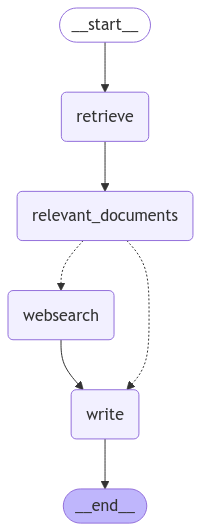

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png())) # 정의된 워크플로우(app)의 그래프를 가져와 PNG 이미지로 변환
except Exception:
    pass

In [ ]:
from pprint import pprint
inputs = {"question": "프롬프트 엔지니어링이란?"} # 워크폴로우 실행에 필요한 입력 데이터
for output in app.stream(inputs): # 스트리밍 방식으로 결과를 생성
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---검색---
'Finished running: retrieve:'
---문서가 질문과 관련이 있는지 확인하세요---
---평가: 관련 있음---
---평가: 관련 있음---
---문서 검토---
---write: 답변을 생성합니다---
'Finished running: relevant_documents:'
---답변 생성---
'Finished running: write:'
AIMessage(content='프롬프트 엔지니어링이란 인공지능 모델에게 지시나 질문을 전달하기 위해 프롬프트를 설계하고 구성하는 기술입니다. 이는 모델이 더 나은 결과를 생성할 수 있도록 정보를 제공하는 방법을 최적화하는 과정입니다. 프롬프트의 구성 요소와 설계 방법에 따라 결과의 질이 달라질 수 있습니다.', additional_kwargs={}, response_metadata={'finish_reason': 'stop'}, id='run-c6426b07-7c28-4367-95c8-3db2536b6df9-0')
